In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import types
import pdb
import fastai 
from fastai.text import *
from fastai.text.data import *

In [3]:
path = Path("../base/")
ds_path = path/"dataset"

In [4]:
df = pd.read_csv(filepath_or_buffer = path/"info.csv",sep =",",skipinitialspace=True,quotechar = "\"")

1249.0

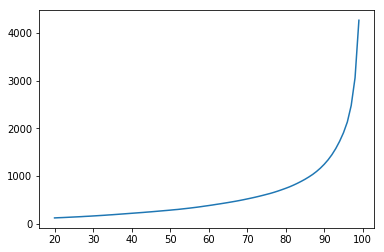

In [5]:
plt.plot(range(20,100),np.percentile([len(o) for o in df.Body],range(20,100)))
np.percentile([len(o) for o in df.Body],90)

In [6]:
len(df)

2000050

In [7]:
perc = np.percentile([len(o) for o in df.Body],2)
df = df.loc[[len(o) for o in df['Body']] < perc]
len(df)

39041

In [46]:
perc = np.percentile([len(o) for o in df.Body],20)
df = df.loc[[len(o) for o in df['Body']] < perc]
len(df)

30748

In [48]:
s ="xvvvaaaav"
r = r"(xxnl|//|[\;\.\,\\\+\-\*\/\+\&\?\#\"\'\!\%\@\:\|\$\^\(\)\[\]\{\}\`])"
re.sub(r, r" \1 ", s)

'xvvvaaaav'

In [8]:
data_lm3 = (TextList.from_df(df,path,"Body"))
# type = TextList
# data_lm3.procesor = [TokenizeProcessor(tokenizer=Tokenizer(n_cpus = 1)), NumericalizeProcessor]
# data_lm3.procesor = [NumericalizeProcessor]


#              .random_split_by_pct(0.1)
#              .label_for_lm() 
#              .databunch(bs=64))
type(data_lm3)

fastai.text.data.TextList

In [9]:
data_lm2 = data_lm3.random_split_by_pct(0.1, seed = 0)
type(data_lm2)

fastai.data_block.ItemLists

In [10]:
def getattrWithoutProcessing(self, k):
        ft = getattr(self.train, k)
        if not isinstance(ft, Callable): return ft
        fv = getattr(self.valid, k)
        assert isinstance(fv, Callable)
        def _inner(*args, **kwargs):
            self.train = ft(*args, **kwargs)
            assert isinstance(self.train, LabelList)
            kwargs['label_cls'] = self.train.y.__class__
            self.valid = fv(*args, **kwargs)
            self.__class__ = LabelLists
#             self.process()
            return self
        return _inner

In [11]:
class SimpleTokinizer(BaseTokenizer):
    def __init__(self, lang = None):
        pass
    def tokenizer(self, t:str) -> List[str]:
#         r = r"(xxnl|//|[\;\.\,\\\+\-\*\/\=\&\?\#\"\'\!\%\@\:\|\$\^\(\)\[\]\{\}\`])"
        r = r"(xxnl|//|[\;\.\,\\\+\-\*\/\=\&\?\#\"\'\!\%\@\:\|\$\^\(\)\[\]\{\}\`\<\>\~\_])"
        mult_spaces = re.sub(r, r" \1 ", t)
        return rm_useless_spaces(mult_spaces).split(" ")

In [14]:
for i in range(0, 15):
    print(df["Body"].iloc[i])
    print(" ".join(SimpleTokinizer().tokenizer(df["Body"].iloc[i])))

/**xxnl * when the button is clicked, will go to the indicated card.xxnl * @param e the actioneventxxnl */xxnlpublic void action Performed(Action Event e) {xxnl    this.layout.get Layout().show(this.layout.get Parent(), slide Name);xxnl}
 / * * xxnl * when the button is clicked , will go to the indicated card . xxnl * @ param e the actionevent xxnl * / xxnl public void action Performed ( Action Event e ) { xxnl this . layout . get Layout ( ) . show ( this . layout . get Parent ( ) , slide Name ) ; xxnl } 
/**xxnl * when the button is clicked, will go to the indicated card.xxnl * @param e the actioneventxxnl */xxnlpublic void action Performed(Action Event e) {xxnl    this.layout.get Layout().show(this.layout.get Parent(), slide Name);xxnl}
 / * * xxnl * when the button is clicked , will go to the indicated card . xxnl * @ param e the actionevent xxnl * / xxnl public void action Performed ( Action Event e ) { xxnl this . layout . get Layout ( ) . show ( this . layout . get Parent ( ) , s

In [12]:
def deal_caps_bug_fix(x:Collection[str]) -> Collection[str]:
    "Replace all words in `x` by their lower version and add `TK_MAJ`."
    res = []
    for t in x:
        if(len(t)>1):
            if t[0].isupper() and t[1:].islower(): res.append(TK_MAJ)
        res.append(t.lower())
    return res

In [13]:
# data_lm2.__getattr__ = types.MethodType(getattrWithoutProcessing, data_lm2)
ItemLists.__getattr__ = getattrWithoutProcessing

In [14]:
data_lm1 = data_lm2.label_for_lm() 
type(data_lm1)

fastai.data_block.LabelLists

In [15]:
data_lm1.train.x.processor = [TokenizeProcessor(ds = data_lm1.train.x,tokenizer = Tokenizer(tok_func = SimpleTokinizer,n_cpus = 1,post_rules = [replace_all_caps, deal_caps_bug_fix])), NumericalizeProcessor(ds = data_lm1.train.x)]

In [16]:
data_lm1.process()

LabelLists;

Train: LabelList
y: LMLabel (35137 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ..\base
x: LMTextList (35137 items)
[Text xxbos xxmaj iterable < xxmaj medication > tagmethodname ( ) ; , Text xxbos void tagmethodname ( xxmaj medication medication ) ; , Text xxbos public xxmaj iterable < xxmaj question > tagmethodname ( ) ; , Text xxbos public void tagmethodname ( xxmaj question question ) ; , Text xxbos public xxmaj iterable < xxmaj response > tagmethodname ( ) ; ]...
Path: ..\base;

Valid: LabelList
y: LMLabel (3904 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ..\base
x: LMTextList (3904 items)
[Text xxbos public xxmaj string tagmethodname ( xxmaj string extension ) ; , Text xxbos @ xxmaj override tagnewline xxmaj psi xxmaj class tagmethodname ( ) ; , Text xxbos public boolean tagmethodname ( ) ; , Text xxbos void tagmethodname ( ) ; , Text xxbos void tagmethodname ( ) ; ]...
Path: ..\base;

Test: None

In [17]:
class LogTokenizeProcessor(TokenizeProcessor):
    def __init__(self, ds:ItemList=None, chunksize:int=10000, mark_fields:bool=False):
        super().__init__(ds = ds, tokenizer = Tokenizer(n_cpus = 1), chunksize = chunksize, mark_fields= mark_fields)

    def process_one(self, item):
        print("p_o: ",item)
        return super().process_one(tem)
    def process(self, ds):
        print("p: ", ds.items[0])       
        ds.items = fastai.text.data._join_texts(ds.items, self.mark_fields)
        tokens = []
        try:
            for i in progress_bar(range(0,len(ds),self.chunksize), leave=False):
                lastChunk = ds.items[i:i+self.chunksize]
                tokens += self.tokenizer.process_all(ds.items[i:i+self.chunksize])                
        except:
            print(lastChunk)
        ds.items = tokens

In [42]:
print(data_lm1.train.x.processor)
data_lm1.train.x.processor = [LogTokenizeProcessor(ds = data_lm1.train.x,chunksize = 1), NumericalizeProcessor(ds = data_lm1.train.x)]
# data_lm1.train.x.processor = [TokenizeProcessor(ds = data_lm1.train.x,tokenizer = Tokenizer(n_cpus = 1),chunksize = 500),
#                               NumericalizeProcessor(ds = data_lm1.train.x)]
print(data_lm1.train.x.processor)

[<__main__.LogTokenizeProcessor object at 0x000001EC044A3B00>, <fastai.text.data.NumericalizeProcessor object at 0x000001EC044A30B8>]
[<__main__.LogTokenizeProcessor object at 0x000001EC044A6240>, <fastai.text.data.NumericalizeProcessor object at 0x000001EC044A63C8>]


In [43]:
type(data_lm1.train.x.items[0])

str

In [18]:
data_lm = data_lm1.databunch(bs=36)

In [91]:
type(data_lm)

fastai.text.data.TextLMDataBunch

In [19]:
data_lm.save('tmp_lm_2p')

In [22]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm_2m_fix', bs=36)

In [10]:
old_itos = data_lm.train_ds.vocab.itos
old_itos

In [20]:
data_lm.show_batch()

In [37]:
def my_label_for_lm(self, **kwargs):
    self.__class__ = text.data.LMTextList
    print(kwargs)
    kwargs.pop("label_cls",None)
    return self.label_const(0, label_cls=text.data.LMLabel,**kwargs)


In [38]:
TextList.label_for_lm = my_label_for_lm

In [ ]:
process = [LogTokenizeProcessor, NumericalizeProcessor]
def test_pdb_example():    
    pdb.set_trace()  
    data_lm1 = data_lm2.label_for_lm(procesor = [LogTokenizeProcessor, NumericalizeProcessor]) 

test_pdb_example()


> <ipython-input-35-8520f1fc7810>(4)test_pdb_example()
-> data_lm1 = data_lm2.label_for_lm(procesor = [LogTokenizeProcessor, NumericalizeProcessor])
(Pdb) s
--Call--
> <ipython-input-24-36792b5d4aa4>(1)getattrWithoutProcessing()
-> def getattrWithoutProcessing(self, k):
(Pdb) n
> <ipython-input-24-36792b5d4aa4>(2)getattrWithoutProcessing()
-> ft = getattr(self.train, k)
(Pdb) 
> <ipython-input-24-36792b5d4aa4>(3)getattrWithoutProcessing()
-> if not isinstance(ft, Callable): return ft
(Pdb) 
> <ipython-input-24-36792b5d4aa4>(4)getattrWithoutProcessing()
-> fv = getattr(self.valid, k)
(Pdb) 
> <ipython-input-24-36792b5d4aa4>(5)getattrWithoutProcessing()
-> assert isinstance(fv, Callable)
(Pdb) 
> <ipython-input-24-36792b5d4aa4>(6)getattrWithoutProcessing()
-> def _inner(*args, **kwargs):
(Pdb) n
> <ipython-input-24-36792b5d4aa4>(14)getattrWithoutProcessing()
-> return _inner
(Pdb) l
  9  	            kwargs['label_cls'] = self.train.y.__class__
 10  	            self.valid = fv(*args, **

In [ ]:
data_lm.save('tmp_lm_50t')

In [9]:
data_lm.show_batch()

In [ ]:
??path.ls

In [15]:
tmp1 = kwargs["procesor"][0];
self.train.x.processor = [tmp1(ds = self.train.x)]
# self.train.y.processor = [tmp1]

(__main__.LogTokenizeProcessor,)

In [ ]:
df.head

In [ ]:
df.Body[0]

## Language Model

In [23]:
# learn = language_model_learner(data_lm)
learn = language_model_learner(data_lm)

In [17]:
 def load_pretrained_fixed(self, wgts_fname:str,  itos_old:Collection[str]):
        "Load a pretrained model and adapts it to the data vocabulary."
        old_itos = itos_old
        old_stoi = {v:k for k,v in enumerate(old_itos)}
        wgts = torch.load(wgts_fname, map_location=lambda storage, loc: storage)
        if 'model' in wgts: wgts = wgts['model']
        wgts = convert_weights(wgts, old_stoi, self.data.train_ds.vocab.itos)
        self.model.load_state_dict(wgts)

In [18]:
LanguageLearner.load_pretrained = load_pretrained_fixed

In [19]:
learn.load_pretrained(path/"models/20m__5_h.pth",old_itos)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


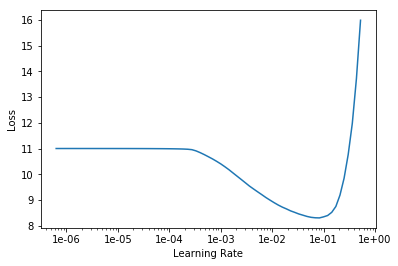

In [10]:
learn.recorder.plot(skip_end=5)

In [6]:
learn.fit_one_cycle(1, 2e-4)

In [10]:
learn.save('20m__13_h_f')

In [6]:
learn.load('20m__13_h_f')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (1620022 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ..\base
x: LMTextList (1620022 items)
[Text xxbos / * * xxnl * when the button is clicked , will go to the indicated card . xxnl * @ param e the actionevent xxnl * / xxnl public void action xxmaj performed ( xxmaj action xxmaj event e ) { xxnl this . layout . get xxmaj layout ( ) . show ( this . layout . get xxmaj parent ( ) , slide xxmaj name ) ; xxnl } , Text xxbos public xxmaj string get xxmaj input ( ) { xxnl return this . input . get xxmaj text ( ) + " 
 " ; xxnl } , Text xxbos public boolean is xxmaj in xxmaj comments ( ) { xxnl return in xxmaj comments ; xxnl } , Text xxbos public void set xxmaj in xxmaj comments ( boolean in xxmaj comments ) { xxnl this . in xxmaj comments = in xxmaj comments ; xxnl } , Text xxbos @ xxmaj override xxnl public boolean equals ( xxmaj object obj ) { xxnl if ( obj = = null ) { xxnl return false ; x

In [11]:
print("\n".join(learn.predict("public void set In Comments ( boolean in Comments ) { xxnl this . in Comments = ", 40, temperature=2) for _ in range(1)))

public void set In Comments ( boolean in Comments ) { xxnl this . in Comments =  ignition 2100 40007 thanflt2args objectstreamclass 203761 worries lirinstruction balor mensagem setparametervalue interceptor predicatemode organisation fmod alivenode measurements wizarddialog maxwait getchildnodes modelmap ff00l idescriptorprovider deserializing leaseduration mydelegate warrior settransform nested1 fairly androkom relativize bytearray dnacs god uploaddate including getformats protectedareablock student


In [10]:
print("\n".join(learn.predict("Array List(", 40, temperature=10) for _ in range(1)))

Array List( taxonomy suffixbits wird nosuchbookingexception dataio integrator v�rdet isnotnull versionproperties facets columnid xads underconstruction gbp getdelegate cl victimid rab assertnull router 863 ctor serversideencryption ielementdefn usernames partnerrole ignite banking netcdf orientationrequestedtype jruby attributedefinition buyercode getaccessiblechild targetsqltype noperms ondataset ftpconfigurationinterface proportional onxxx


In [ ]:
def custom_predict_language_learner(model, text,  n_words, temperature=1):
    ds = learn.data.single_dl.dataset
    learn.model.eval()
    for _ in range(n_words):
        xb, yb = self.data.one_item(text)
#         ds.set_item(text)
#         x, _ = next(iter(ds))

        pdb.set_trace()
        x = torch.tensor(x, device="cpu").view(-1, 1)
        res = learn.model(x)[0][-1]
        ds.clear_item()
        res /= temperature
        idx = torch.distributions.Multinomial(logits=res, total_count=1).sample((1, )).argmax().item()
        text += f' {learn.data.vocab.itos[idx]}'
    return text

In [ ]:
print("Custom implementation of predict:")
print("\n".join(custom_predict_language_learner(learn.model, "public void set In Comments ( boolean in Comments ) { xxnl this . in Comments = ", 40) 
                for _ in range(1)))

Custom implementation of predict:
> <ipython-input-16-01b1f300b155>(8)custom_predict_language_learner()
-> x = torch.tensor(x, device="cpu").view(-1, 1)
(Pdb) p x
Text xxbos / * * xxnl * xxmaj the number of xxmaj capacity xxmaj units of the provisioned throughput of the xxnl * table consumed during the operation . < code > getitem < / code > , xxnl * < code > batchgetitem < / code > , < code > batchwriteitem < / code > , xxnl * < code > xxmaj query < / code > , and < code > xxmaj scan < / code > operations consume xxnl * < code > readcapacityunits < / code > , while < code > putitem < / code > , xxnl * < code > updateitem < / code > , and < code > deleteitem < / code > operations xxnl * consume < code > writecapacityunits < / code > . xxnl * xxnl * @ return xxmaj the number of xxmaj capacity xxmaj units of the provisioned throughput of the xxnl * table consumed during the operation . < code > getitem < / code > , xxnl * < code > batchgetitem < / code > , < code > batchwriteitem < / cod

In [28]:
learn.model.state_dict()

OrderedDict([('0.encoder.weight',
              tensor([[ 0.0582,  0.0979, -0.0310,  ..., -0.0967, -0.0788,  0.0865],
                      [-0.0924,  0.0003,  0.0864,  ..., -0.0536,  0.0189,  0.0432],
                      [-0.0494, -0.0045, -0.0248,  ...,  0.0889, -0.0832, -0.0962],
                      ...,
                      [ 0.0715, -0.0008,  0.0058,  ...,  0.0150,  0.0922, -0.0382],
                      [ 0.0044, -0.0614, -0.0353,  ..., -0.0674,  0.0629, -0.0830],
                      [-0.0825, -0.0226, -0.0523,  ...,  0.0947,  0.0337, -0.0806]],
                     device='cuda:0')),
             ('0.encoder_dp.emb.weight',
              tensor([[ 0.0582,  0.0979, -0.0310,  ..., -0.0967, -0.0788,  0.0865],
                      [-0.0924,  0.0003,  0.0864,  ..., -0.0536,  0.0189,  0.0432],
                      [-0.0494, -0.0045, -0.0248,  ...,  0.0889, -0.0832, -0.0962],
                      ...,
                      [ 0.0715, -0.0008,  0.0058,  ...,  0.0150,  0.0922, 

## Clasifier

In [9]:
df = pd.read_csv(filepath_or_buffer = path/"info.csv",sep =",",skipinitialspace=True,quotechar = "\"")

1089.0

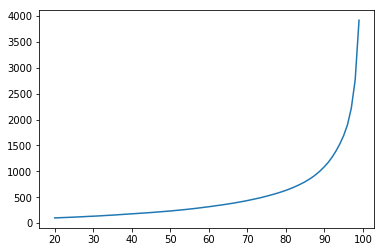

In [10]:
plt.plot(range(20,100),np.percentile([len(o) for o in df.Body],range(20,100)))
np.percentile([len(o) for o in df.Body],90)

In [11]:
len(df)

2000050

In [12]:
perc = np.percentile([len(o) for o in df.Body],90)
df = df.loc[[len(o) for o in df['Body']] < perc]
len(df)

1800024

In [14]:
df.iloc[1]

MethodName                                     action Performed
Body          /**xxnl * when the button is clicked, will go ...
Name: 1, dtype: object

In [10]:
data_lm3 = (TextDataBunch.from_df(df,path,"Body"))
# type = TextList
# data_lm3.procesor = [TokenizeProcessor(tokenizer=Tokenizer(n_cpus = 1)), NumericalizeProcessor]
# data_lm3.procesor = [NumericalizeProcessor]


#              .random_split_by_pct(0.1)
#              .label_for_lm() 
#              .databunch(bs=64))
type(data_lm3)

fastai.text.data.TextList

In [11]:
data_lm2 = data_lm3.random_split_by_pct(0.1, seed = 0)
type(data_lm2)

fastai.data_block.ItemLists

In [12]:
def getattrWithoutProcessing(self, k):
        ft = getattr(self.train, k)
        if not isinstance(ft, Callable): return ft
        fv = getattr(self.valid, k)
        assert isinstance(fv, Callable)
        def _inner(*args, **kwargs):
            self.train = ft(*args, **kwargs)
            assert isinstance(self.train, LabelList)
            kwargs['label_cls'] = self.train.y.__class__
            self.valid = fv(*args, **kwargs)
            self.__class__ = LabelLists
#             self.process()
            return self
        return _inner

In [13]:
class SimpleTokinizer(BaseTokenizer):
    def __init__(self, lang = None):
        pass
    def tokenizer(self, t:str) -> List[str]:
#         r = r"(xxnl|//|[\;\.\,\\\+\-\*\/\=\&\?\#\"\'\!\%\@\:\|\$\^\(\)\[\]\{\}\`])"
        r = r"(xxnl|//|[\;\.\,\\\+\-\*\/\=\&\?\#\"\'\!\%\@\:\|\$\^\(\)\[\]\{\}\`\<\>\~\_])"
        mult_spaces = re.sub(r, r" \1 ", t)
        return rm_useless_spaces(mult_spaces).split(" ")